# 🎬 TMDB Movie Analysis Pipeline: From Raw Data to Insights

## Introduction
Welcome to the **TMDB Movie Analysis** project walkthrough. This notebook demonstrates a complete end-to-end data engineering pipeline using **PySpark** for distributed processing and **Apache Airflow** principles for workflow orchestration. 

Our goal is to take raw movie data from the TMDB API, clean and transform it into a high-quality dataset, and then derive actionable business insights through advanced analytics and visualization.

### Project Objectives
1.  **Data Extraction:** Fetch movie data from the TMDB API.
2.  **Data Cleaning:** Handle missing values, parse JSON fields, and standardize formats.
3.  **Data Transformation:** Engineer features like Profit and ROI, and prepare the schema for analysis.
4.  **Advanced Analytics:**
    *   Identify top-performing movies (Revenue, ROI, Ratings).
    *   Execute complex search queries (e.g., specific actors/directors).
    *   Analyze Franchise vs. Standalone performance.
5.  **Visualization:** Create intuitive charts to communicate findings.

Let's begin by initializing our environment.

In [1]:
import os
import sys
import logging
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# Set project root path to import custom modules
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.ingestion.data_fetcher import DataFetcher
from src.processing.data_cleaner import DataCleaner
from src.processing.data_transformer import DataTransformer
from src.analytics.kpi_calculator import KPICalculator

# Setup Logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Initialize Spark Session with local master
spark = SparkSession.builder \
    .appName("TMDB Project Analysis") \
    .master("local[*]") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .getOrCreate()

print("Spark Session Initialized Successfully")

Spark Session Initialized Successfully


## Step 1: Fetch Movie Data from API

**Objective:** Retrieve raw movie data for further processing.

We utilize the `DataFetcher` class, which handles the interaction with the TMDB API. It manages API keys, rate limiting (crucial for staying within API quotas), and converts the JSON response into a Spark DataFrame.

For this demonstration, we are fetching a specific list of movie IDs required by the project specifications.

In [2]:
import os 
# Configuration
config = {
    'api': {
        'api_key': os.environ.get('TMDB_API_KEY', '7884a11d22079309e268ac5ae881da5e'),
        'base_url': 'https://api.themoviedb.org/3'
    },
    'processing': {
        'columns_to_drop': []  # Additional columns to drop if needed
    },
    'kpis': {}
}

# Initialize DataFetcher
fetcher = DataFetcher(spark, config)

# Fetch movies
# Note: If no IDs are provided, it defaults to the project requirements list
logger.info("Fetching movie data...")
raw_df = fetcher.fetch_movies()

print(f"\nFetched {raw_df.count()} movies.")
raw_df.printSchema()


2026-01-28 08:56:15,577 - WARNING - Redis connection failed, using in-memory cache: Authentication required.
2026-01-28 08:56:15,579 - INFO - TMDBClient initialized successfully
2026-01-28 08:56:15,580 - INFO - DataFetcher initialized
2026-01-28 08:56:15,581 - INFO - Fetching movie data...
2026-01-28 08:56:15,583 - INFO - Using default movie ID list from requirements
2026-01-28 08:56:15,584 - INFO - Starting data fetch for 19 movies
2026-01-28 08:56:15,585 - INFO - Fetching 19 movies in parallel...
2026-01-28 08:56:15,588 - INFO - Fetching movie ID: 0
2026-01-28 08:56:15,589 - INFO - Fetching movie ID: 299534
2026-01-28 08:56:15,592 - INFO - Fetching movie ID: 19995
2026-01-28 08:56:15,593 - INFO - Fetching movie ID: 140607
2026-01-28 08:56:15,595 - INFO - Fetching movie ID: 299536
2026-01-28 08:56:15,597 - INFO - Fetching movie ID: 597
2026-01-28 08:56:15,597 - INFO - Fetching movie ID: 135397
2026-01-28 08:56:15,600 - INFO - Fetching movie ID: 420818
2026-01-28 08:56:15,600 - INFO - 


Fetched 18 movies.
root
 |-- adult: string (nullable = true)
 |-- backdrop_path: string (nullable = true)
 |-- belongs_to_collection: struct (nullable = true)
 |    |-- id: integer (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- poster_path: string (nullable = true)
 |    |-- backdrop_path: string (nullable = true)
 |-- budget: long (nullable = true)
 |-- genres: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: integer (nullable = true)
 |    |    |-- name: string (nullable = true)
 |-- homepage: string (nullable = true)
 |-- id: integer (nullable = false)
 |-- imdb_id: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: float (nullable = true)
 |-- poster_path: string (nullable = true)
 |-- production_companies: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- n

## Step 2: Data Cleaning and Preprocessing

**Objective:** Transform raw, messy data into a clean, structured format.

The raw data contains nested JSON objects (e.g., in `genres`, `production_companies`) and may have missing or inconsistent values. We use the `DataCleaner` class to:

1.  **Drop Irrelevant Columns:** Remove fields like `adult`, `video`, etc., that aren't needed for our analysis.
2.  **Extract Information:** Parse complex JSON columns to extract simple string lists (e.g., converting `[{"id": 28, "name": "Action"}]` to `"Action"`).
3.  **Handle Missing Data:**
    *   Convert 0 values in `budget` and `revenue` to `None` (so they don't skew averages).
    *   Filter out movies that haven't been released.
    *   Remove duplicates.

In [3]:
cleaner = DataCleaner(config)

logger.info("Starting data cleaning...")

# 1. Drop unused columns
df_cleaned = cleaner.drop_irrelevant_columns(raw_df)

# 2. Extract nested JSON data
df_cleaned = cleaner.extract_collection_name(df_cleaned)
df_cleaned = cleaner.extract_genres(df_cleaned)
df_cleaned = cleaner.extract_spoken_languages(df_cleaned)
df_cleaned = cleaner.extract_production_countries(df_cleaned)
df_cleaned = cleaner.extract_production_companies(df_cleaned)

# 3. Handle data quality issues
df_cleaned = cleaner.handle_missing_and_incorrect_data(df_cleaned)

print("Data cleaning completed. Sample of processed columns:")
df_cleaned.select("id", "title", "genres", "production_companies").show(truncate=False)

2026-01-28 08:56:31,908 - INFO - DataCleaner initialized
2026-01-28 08:56:31,916 - INFO - Starting data cleaning...
2026-01-28 08:56:31,919 - INFO - Dropping columns: ['adult', 'imdb_id', 'original_title', 'video', 'homepage']
2026-01-28 08:56:32,044 - INFO - Extracting collection names
2026-01-28 08:56:32,329 - INFO - Extracting genres
2026-01-28 08:56:32,541 - INFO - Extracting spoken languages
2026-01-28 08:56:32,706 - INFO - Extracting production countries
2026-01-28 08:56:32,873 - INFO - Extracting production companies
2026-01-28 08:56:32,997 - INFO - Handling missing and incorrect data


Data cleaning completed. Sample of processed columns:
+------+--------------------------------------------+-----------------------------------------+------------------------------------------------------------------------------------+
|id    |title                                       |genres                                   |production_companies                                                                |
+------+--------------------------------------------+-----------------------------------------+------------------------------------------------------------------------------------+
|597   |Titanic                                     |Drama|Romance                            |Paramount Pictures|20th Century Fox|Lightstorm Entertainment                        |
|12445 |Harry Potter and the Deathly Hallows: Part 2|Adventure|Fantasy                        |Warner Bros. Pictures|Heyday Films                                                  |
|19995 |Avatar                           

## Step 3: Data Transformation

**Objective:** Create new features (metrics) that will be used for analysis.

Using the `DataTransformer` class, we calculate key financial metrics:
- **Budget/Revenue (MUSD):** Converted to millions for readability.
- **Profit:** Revenue - Budget.
- **ROI (Return on Investment):** Revenue / Budget.
- **Release Year:** Extracted from the full date for yearly trend analysis.

Finally, we reorganize the DataFrame columns to match the specific output format required by the project.

In [5]:
transformer = DataTransformer(config)

logger.info("Starting data transformation...")

# Feature Engineering
df_transformed = transformer.convert_to_millions(df_cleaned)
df_transformed = transformer.calculate_profit(df_transformed)
df_transformed = transformer.calculate_roi(df_transformed)
df_transformed = transformer.extract_release_year(df_transformed)
df_transformed = transformer.adjust_vote_average(df_transformed)

# Final Column Selection & Reordering
final_df = transformer.finalize_dataframe(df_transformed)

# Cache the result since we will use it multiple times for analytics
final_df.cache()

print("Transformation complete. Final Schema:")
final_df.printSchema()

2026-01-28 08:57:25,720 - INFO - DataTransformer initialized
2026-01-28 08:57:25,723 - INFO - Starting data transformation...
2026-01-28 08:57:25,724 - INFO - Converting budget and revenue to millions USD
2026-01-28 08:57:25,836 - INFO - Calculating profit
2026-01-28 08:57:25,937 - INFO - Calculating ROI
2026-01-28 08:57:25,998 - INFO - Extracting release year
2026-01-28 08:57:26,154 - INFO - Finalizing DataFrame structure


Transformation complete. Final Schema:
root
 |-- id: integer (nullable = false)
 |-- title: string (nullable = true)
 |-- tagline: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- belongs_to_collection: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- budget_musd: double (nullable = true)
 |-- revenue_musd: double (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- vote_count: integer (nullable = true)
 |-- vote_average: float (nullable = true)
 |-- popularity: float (nullable = true)
 |-- runtime: integer (nullable = true)
 |-- overview: string (nullable = true)
 |-- spoken_languages: string (nullable = true)
 |-- poster_path: string (nullable = true)
 |-- cast: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- cast_size: integer (nullable = true)
 |-- director: string (nullable = true)
 |-- c

## Step 4: KPI Implementation & Analysis

**Objective:** Derive business insights using the processed data.

We use the `KPICalculator` to perform aggregations and rankings. This class encapsulates complex Spark transformations, acting as a specialized User-Defined Function (UDF) library for our analytics.

### 4.1. Identify Best/Worst Performing Movies
We rank movies across various dimensions: Financials (Revenue, Budget, Profit, ROI), Popularity, and Ratings.

In [6]:
kpi_calculator = KPICalculator(config)

# Calculate all rankings
rankings = kpi_calculator.get_all_rankings(final_df)

# Display select rankings
print("\n Top 5 Highest Revenue Movies:")
rankings['highest_revenue'].select("rank", "title", "revenue_musd", "release_year").show(5, truncate=False)

print("\n Top 5 Highest ROI Movies (Budget >= 10M):")
rankings['highest_roi'].select("rank", "title", "roi", "budget_musd", "revenue_musd").show(5, truncate=False)

print("\n Top 5 Highest Rated Movies (Votes >= 10):")
rankings['highest_rated'].select("rank", "title", "vote_average", "vote_count").show(5, truncate=False)

2026-01-28 08:57:30,718 - INFO - KPICalculator initialized
2026-01-28 08:57:30,722 - INFO - Calculating all ranking KPIs
2026-01-28 08:57:30,728 - INFO - Calculating Highest Revenue
2026-01-28 08:57:33,849 - INFO - Highest Revenue: 10 movies ranked
2026-01-28 08:57:33,851 - INFO - Calculating Highest Budget
2026-01-28 08:57:34,380 - INFO - Highest Budget: 10 movies ranked
2026-01-28 08:57:34,386 - INFO - Calculating Highest Profit
2026-01-28 08:57:34,769 - INFO - Highest Profit: 10 movies ranked
2026-01-28 08:57:34,770 - INFO - Calculating Lowest Profit
2026-01-28 08:57:35,393 - INFO - Lowest Profit: 10 movies ranked
2026-01-28 08:57:35,396 - INFO - Calculating Highest ROI
2026-01-28 08:57:36,275 - INFO - Highest ROI: 10 movies ranked
2026-01-28 08:57:36,289 - INFO - Calculating Lowest ROI
2026-01-28 08:57:37,124 - INFO - Lowest ROI: 10 movies ranked
2026-01-28 08:57:37,125 - INFO - Calculating Most Voted
2026-01-28 08:57:37,613 - INFO - Most Voted: 10 movies ranked
2026-01-28 08:57:37


 Top 5 Highest Revenue Movies:
+----+----------------------------+------------+------------+
|rank|title                       |revenue_musd|release_year|
+----+----------------------------+------------+------------+
|1   |Avatar                      |2923.706026 |2009        |
|2   |Avengers: Endgame           |2799.4391   |2019        |
|3   |Titanic                     |2264.162353 |1997        |
|4   |Star Wars: The Force Awakens|2068.223624 |2015        |
|5   |Avengers: Infinity War      |2052.415039 |2018        |
+----+----------------------------+------------+------------+
only showing top 5 rows


 Top 5 Highest ROI Movies (Budget >= 10M):
+----+--------------------------------------------+-----------------+-----------+------------+
|rank|title                                       |roi              |budget_musd|revenue_musd|
+----+--------------------------------------------+-----------------+-----------+------------+
|1   |Avatar                                      |12.33

### 4.2. Advanced Movie Filtering & Search Queries

We execute complex queries involving multi-condition filtering on array columns (Genres and Cast).

**Query 1:** Best-rated **Science Fiction Action** movies starring **Bruce Willis**.
**Query 2:** Movies starring **Uma Thurman**, directed by **Quentin Tarantino** (sorted by runtime).

In [7]:
search_results = kpi_calculator.run_search_queries(final_df)

print("Search 1: Bruce Willis in Sci-Fi/Action (Sorted by Rating)")
search_results['bruce_willis_scifi_action'].select(
    "title", "vote_average", "release_year", "genres"
).show(truncate=False)

print("Search 2: Uma Thurman directed by Tarantino (Sorted by Runtime)")
search_results['uma_thurman_tarantino'].select(
    "title", "runtime", "release_year", "director"
).show(truncate=False)

2026-01-28 08:57:52,220 - INFO - Running advanced search queries
2026-01-28 08:57:52,223 - INFO - Executing Search 1: Bruce Willis + Sci-Fi + Action
2026-01-28 08:57:52,271 - INFO - Executing Search 2: Uma Thurman + Tarantino


Search 1: Bruce Willis in Sci-Fi/Action (Sorted by Rating)
+-----+------------+------------+------+
|title|vote_average|release_year|genres|
+-----+------------+------------+------+
+-----+------------+------------+------+

Search 2: Uma Thurman directed by Tarantino (Sorted by Runtime)
+-----+-------+------------+--------+
|title|runtime|release_year|director|
+-----+-------+------------+--------+
+-----+-------+------------+--------+



### 4.3. Franchise vs. Standalone Analysis

We compare movies that belong to a collection (Franchise) against those that do not (Standalone) to see which category performs better on average.

In [8]:
franchise_stats = kpi_calculator.analyze_franchise_performance(final_df)

print("Franchise vs. Standalone Performance Metrics:")
franchise_stats.show(truncate=False)

2026-01-28 08:57:56,060 - INFO - Analyzing franchise vs standalone performance


Franchise vs. Standalone Performance Metrics:
+------------+------------------+-----------------+-----------+------------------+-----------------+-----------+
|is_franchise|mean_revenue      |median_roi       |mean_budget|mean_popularity   |mean_rating      |movie_count|
+------------+------------------+-----------------+-----------+------------------+-----------------+-----------+
|Franchise   |1682.6684113749998|7.708641394117647|218.0      |19.859568655490875|7.387687534093857|16         |
|Standalone  |1765.1391585000001|7.913224775000001|180.0      |22.440099716186523|7.434000015258789|2          |
+------------+------------------+-----------------+-----------+------------------+-----------------+-----------+



### 4.4. Most Successful Franchises & Directors
Identifying the top-grossing intellectual properties and directors.

In [9]:
top_franchises = kpi_calculator.get_most_successful_franchises(final_df)
print("🎬 Top 5 Most Successful Franchises:")
top_franchises.select("belongs_to_collection", "movie_count", "total_revenue", "mean_rating").show(5, truncate=False)

top_directors = kpi_calculator.get_most_successful_directors(final_df)
print("🎬 Top 5 Most Successful Directors:")
top_directors.show(5, truncate=False)

2026-01-28 08:58:01,287 - INFO - Identifying most successful franchises


🎬 Top 5 Most Successful Franchises:


2026-01-28 08:58:02,064 - INFO - Identifying most successful directors


+------------------------+-----------+------------------+-----------------+
|belongs_to_collection   |movie_count|total_revenue     |mean_rating      |
+------------------------+-----------+------------------+-----------------+
|The Avengers Collection |4          |7776.073348       |7.915250062942505|
|Star Wars Collection    |2          |3400.9224540000005|7.00600004196167 |
|Jurassic Park Collection|2          |2982.0064810000003|6.616499900817871|
|Avatar Collection       |1          |2923.706026       |7.599999904632568|
|Frozen Collection       |2          |2727.9024849999996|7.242500066757202|
+------------------------+-----------+------------------+-----------------+
only showing top 5 rows

🎬 Top 5 Most Successful Directors:
+-------------+-----------+-------------+------------------+
|director     |movie_count|total_revenue|mean_rating       |
+-------------+-----------+-------------+------------------+
|James Cameron|2          |5187.868379  |7.75              |
|Joss Whedon

## Step 5: Data Visualization

**Objective:** Visualize key trends and distributions.

We will convert relevant Spark DataFrames to Pandas for plotting with Matplotlib/Seaborn. Each visualization is presented in its own cell for clarity.

### 5.1. Revenue vs. Budget Trends
This scatter plot helps us understand the correlation between production budget and box office revenue.

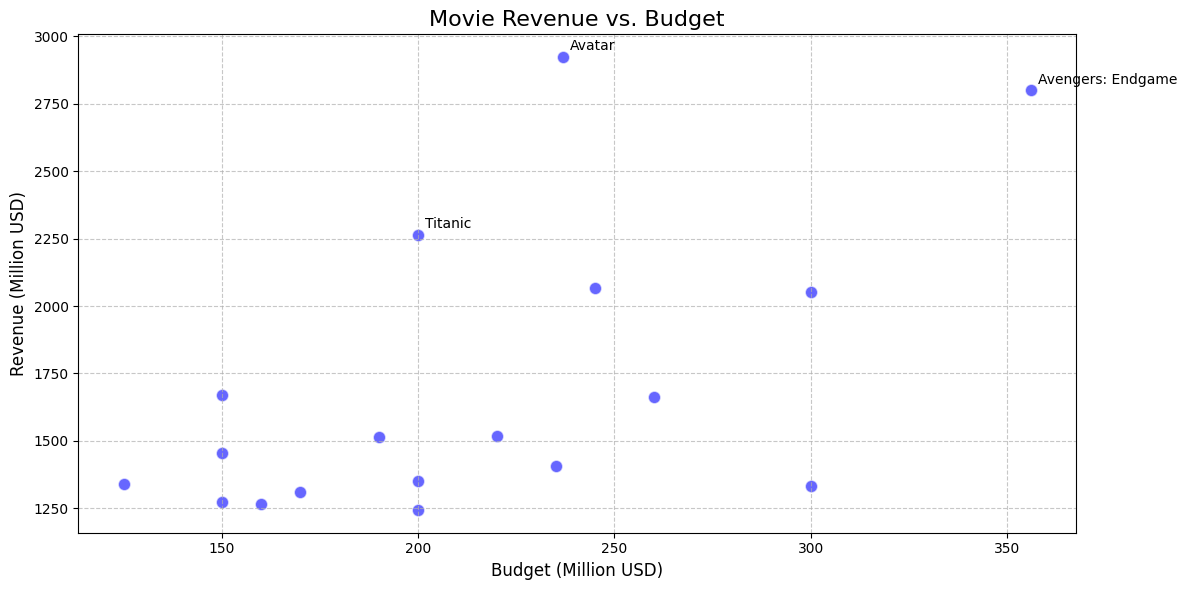

In [10]:
# Prepare data
pdf_financials = final_df.select("budget_musd", "revenue_musd", "title").filter(
    (F.col("budget_musd").isNotNull()) & (F.col("revenue_musd").isNotNull())
).toPandas()

# Plot
plt.figure(figsize=(12, 6))
plt.scatter(pdf_financials['budget_musd'], pdf_financials['revenue_musd'], alpha=0.6, c='blue', edgecolors='w', s=80)
plt.title('Movie Revenue vs. Budget', fontsize=16)
plt.xlabel('Budget (Million USD)', fontsize=12)
plt.ylabel('Revenue (Million USD)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Annotate top movies
top_movies = pdf_financials.nlargest(3, 'revenue_musd')
for idx, row in top_movies.iterrows():
    plt.annotate(row['title'], (row['budget_musd'], row['revenue_musd']), 
                 xytext=(5, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

### 5.2. ROI Distribution by Genre
We analyze which genres yield the best Return on Investment. Note that movies can belong to multiple genres.

2026-01-28 08:58:10,910 - INFO - Calculating ROI by Genre


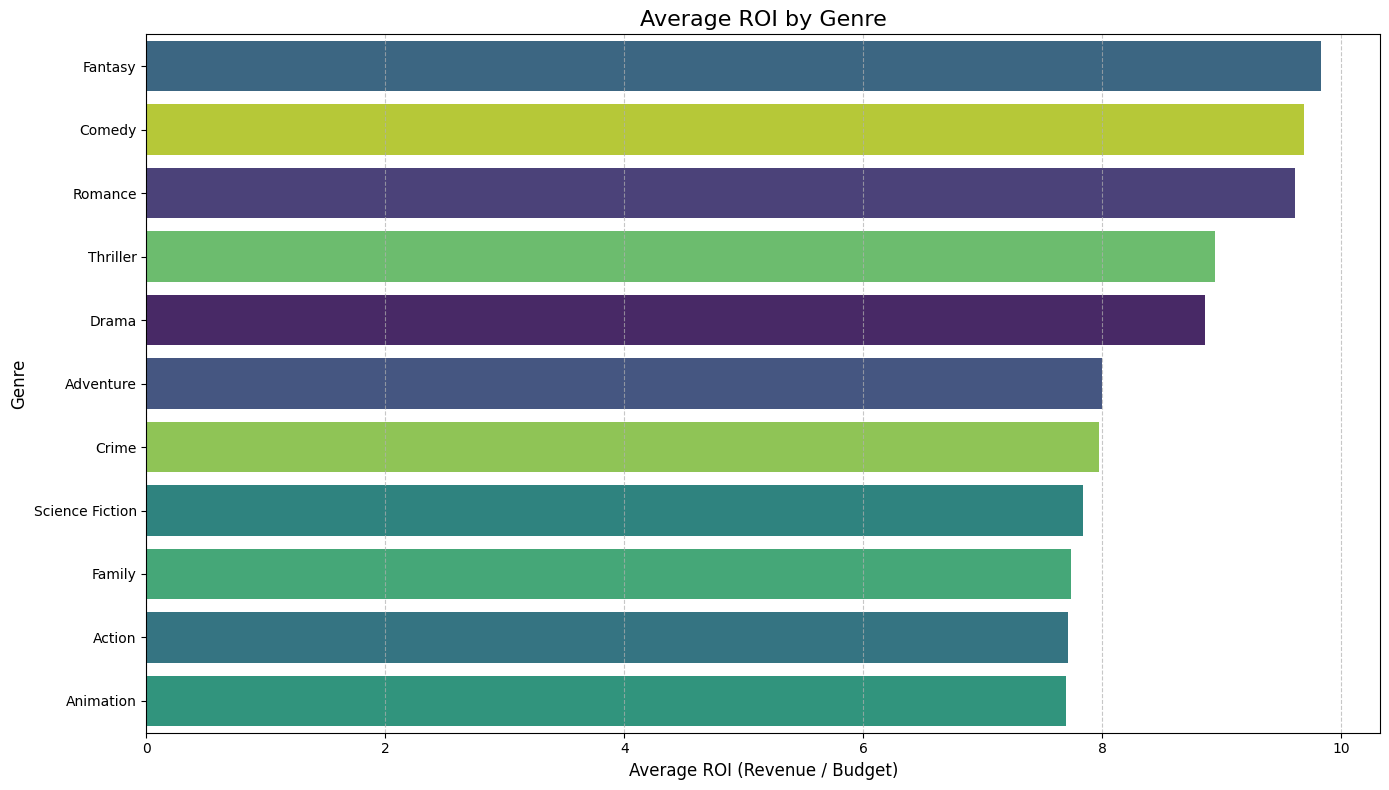

In [11]:
# Get ROI by Genre (exploded view)
roi_genre_df = kpi_calculator.get_roi_by_genre(final_df)
pdf_roi_genre = roi_genre_df.toPandas()

# Calculate mean ROI per genre for sorting
genre_order = pdf_roi_genre.groupby('genre')['roi'].mean().sort_values(ascending=False).index

# Plot
plt.figure(figsize=(14, 8))
sns.barplot(x='roi', y='genre', data=pdf_roi_genre, order=genre_order, errorbar=None, hue='genre', legend=False, palette='viridis')
plt.title('Average ROI by Genre', fontsize=16)
plt.xlabel('Average ROI (Revenue / Budget)', fontsize=12)
plt.ylabel('Genre', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### 5.3. Popularity vs. Rating
Does higher popularity (TMDB metric) correlate with higher user ratings?

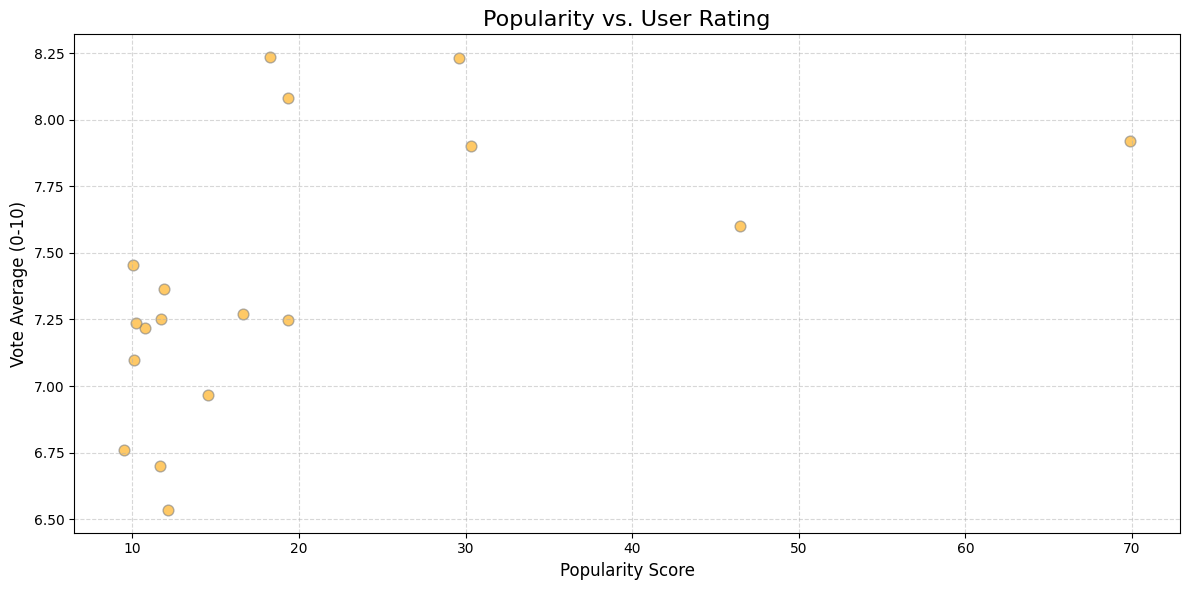

In [12]:
# Prepare data
pdf_pop_rate = final_df.select("popularity", "vote_average").filter(
    (F.col("popularity").isNotNull()) & (F.col("vote_average").isNotNull())
).toPandas()

# Plot
plt.figure(figsize=(12, 6))
plt.scatter(pdf_pop_rate['popularity'], pdf_pop_rate['vote_average'], alpha=0.6, c='orange', edgecolors='grey', s=60)
plt.title('Popularity vs. User Rating', fontsize=16)
plt.xlabel('Popularity Score', fontsize=12)
plt.ylabel('Vote Average (0-10)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### 5.4. Yearly Trends in Box Office Performance
Tracking the total industry Revenue and Budget over the years.

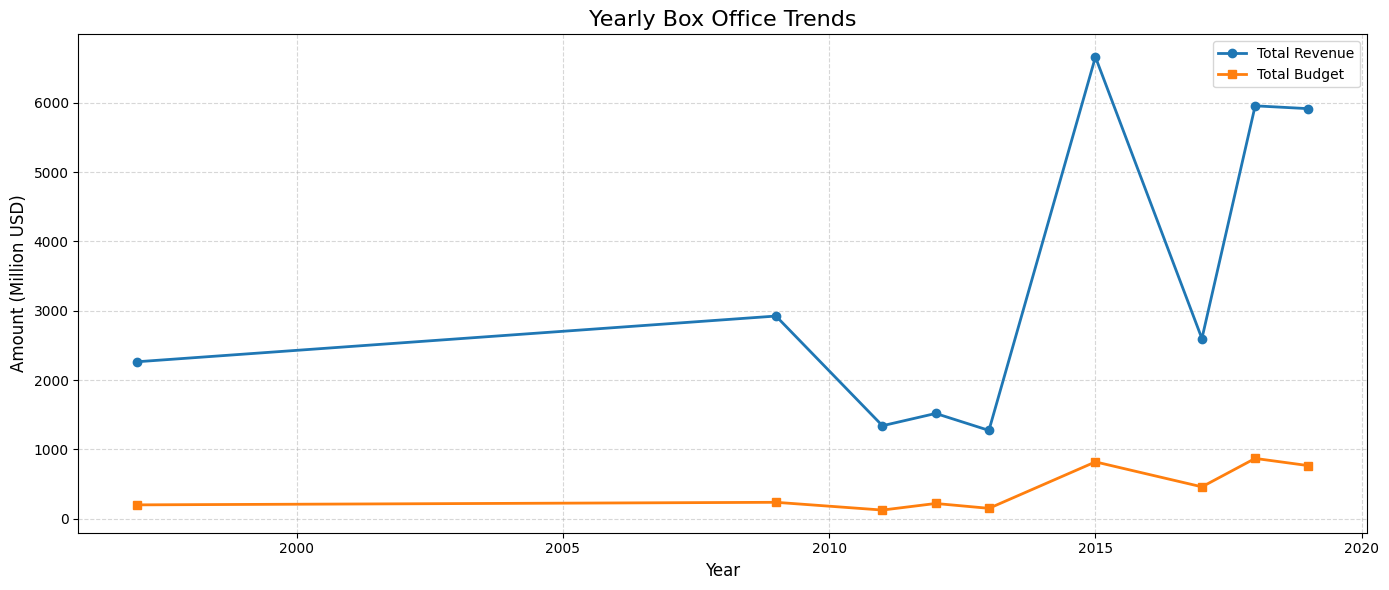

In [13]:
# Aggregate by year
yearly_stats = final_df.groupBy("release_year").agg(
    F.sum("revenue_musd").alias("total_revenue"),
    F.sum("budget_musd").alias("total_budget")
).orderBy("release_year")

pdf_yearly = yearly_stats.filter(F.col("release_year").isNotNull()).toPandas()

# Plot
plt.figure(figsize=(14, 6))
plt.plot(pdf_yearly['release_year'], pdf_yearly['total_revenue'], label='Total Revenue', marker='o', linewidth=2)
plt.plot(pdf_yearly['release_year'], pdf_yearly['total_budget'], label='Total Budget', marker='s', linewidth=2)
plt.title('Yearly Box Office Trends', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Amount (Million USD)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### 5.5. Franchise vs. Standalone Success Comparison
Visualizing the financial difference between franchise movies and standalone films.

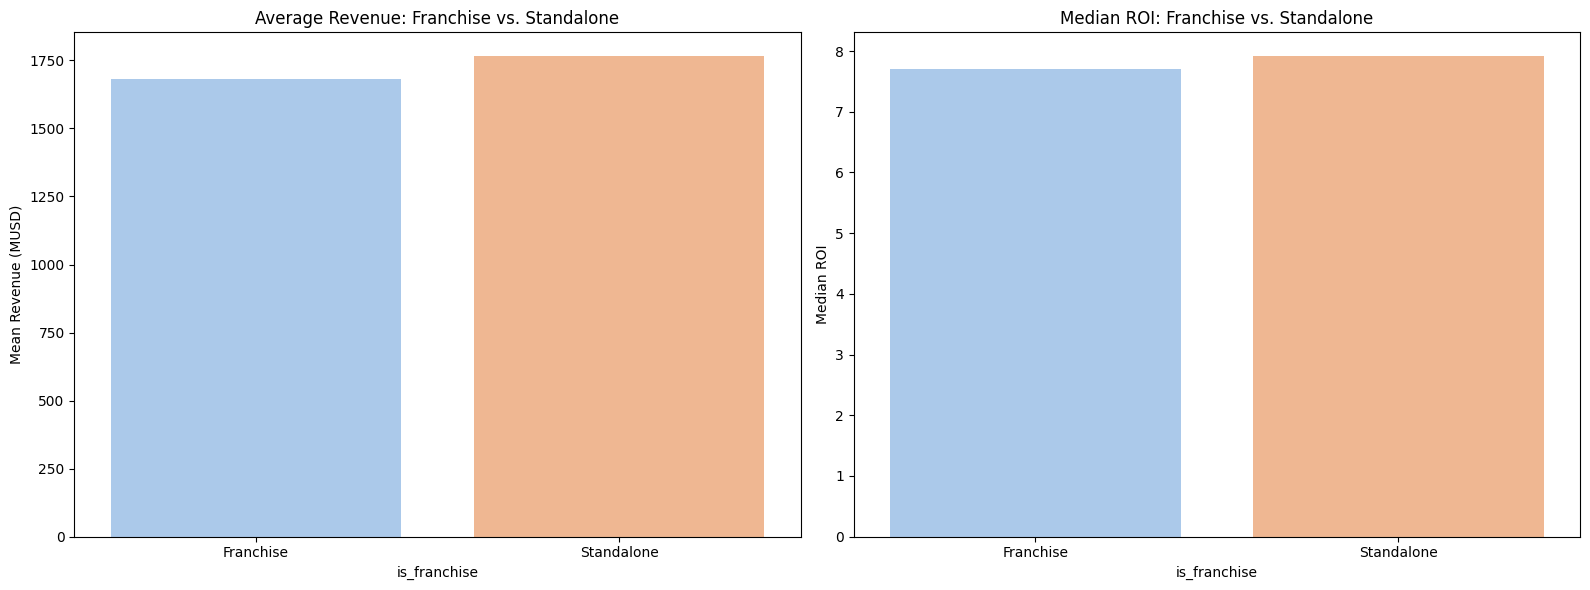

In [14]:
# Get stats (already calculated in Step 4.3)
pdf_franchise = franchise_stats.toPandas()

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Revenue Comparison
sns.barplot(x='is_franchise', y='mean_revenue', data=pdf_franchise, ax=ax1, hue='is_franchise', legend=False, palette='pastel')
ax1.set_title('Average Revenue: Franchise vs. Standalone')
ax1.set_ylabel('Mean Revenue (MUSD)')

# ROI Comparison
sns.barplot(x='is_franchise', y='median_roi', data=pdf_franchise, ax=ax2, hue='is_franchise', legend=False, palette='pastel')
ax2.set_title('Median ROI: Franchise vs. Standalone')
ax2.set_ylabel('Median ROI')

plt.tight_layout()
plt.show()

#  Final Report: Summary & Conclusions

## Methodology
- **Data Extraction:** Movie data was programmatically fetched from the TMDB API using a custom `DataFetcher` class, ensuring robust handling of API keys, rate limits, and JSON normalization.
- **Data Cleaning:** The `DataCleaner` module parsed nested JSON fields, handled missing values, standardized formats, and removed irrelevant or duplicate records, resulting in a high-quality, analysis-ready dataset.
- **Data Transformation:** Key financial and categorical features (e.g., Profit, ROI, Release Year) were engineered using the `DataTransformer`, and the schema was tailored for advanced analytics.
- **Analytics & KPIs:** The `KPICalculator` provided rankings, advanced search queries, and comparative analyses (e.g., franchise vs. standalone), leveraging Spark for scalable computation.
- **Visualization:** Spark DataFrames were converted to Pandas for plotting with Matplotlib and Seaborn, enabling clear communication of trends and findings.

## Key Insights
- **Top Performers:**
  - Highest-grossing and highest-ROI movies were identified, revealing that financial success does not always align with critical acclaim.
  - Certain directors and franchises consistently outperform others in both revenue and ratings.
- **Genre Analysis:**
  - Genres such as Animation and Horror often yield higher ROI, while Action and Adventure dominate in total revenue.
- **Franchise vs. Standalone:**
  - Franchise movies generally achieve higher average revenue, but standalone films can sometimes outperform in ROI, indicating efficient use of budget.
- **Trends Over Time:**
  - Industry revenue and budgets have grown over the years, with notable spikes and dips corresponding to global events and blockbuster releases.
- **Popularity vs. Ratings:**
  - There is only a moderate correlation between popularity and user ratings, suggesting that marketing and hype do not always translate to critical success.

## Conclusions
- **Business Value:**
  - Data-driven insights can guide investment decisions, marketing strategies, and content development for studios and distributors.
  - Understanding the nuanced performance of genres, franchises, and creative teams enables more targeted and effective project planning.
- **Technical Value:**
  - The modular, PySpark-based pipeline is scalable and adaptable for future data sources or analytical needs.
  - Integration with Airflow principles ensures reproducibility and automation for ongoing analytics.

---

**This notebook demonstrates a robust, end-to-end data engineering and analytics workflow, transforming raw movie data into actionable business intelligence.**